In [0]:
!pip install biopython
!pip install transformers

     |████████████████████████████████| 2.3MB 6.2MB/s 
     |████████████████████████████████| 368kB 6.3MB/s 
     |████████████████████████████████| 645kB 41.5MB/s 
     |████████████████████████████████| 1.0MB 56.4MB/s 
     |████████████████████████████████| 860kB 34.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=ebaa87f75210e3d870beccf9c4ef0dd18b9041d875b5b7a9e9208972fb0dc958
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
import os
import gzip
from Bio import SeqIO
from Bio.Data import CodonTable

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [0]:
# load fasta sequence
d = "drive/My Drive/Colab Notebooks/smaug/data/ecoli_MG1655"
genome_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.fna.gz")

with gzip.open(genome_path, 'rt') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = record.seq

# get gene locations
gbff_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.gbff.gz")
gene_loc_list, gene_seq_list = get_CDS_locations(gbff_path)

# total genes and example loc
print(len(gene_loc_list))
print(gene_loc_list[300])

3532
[381350:381716](+)


In [0]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    # softcorrect = softcorrect.item()
    softcorrect = softcorrect


    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# find all ORFs in all reading frames
# # TODO: ORFs can contain smaller ORFs with alternative start codons, which may be the true start codons. Need to extract all possible ORFs to find all true genes
# def find_ORFs(aa_seq, minimum_length):
#     """find positions of all open reading frames in all reading frames"""
#     # ASSUMES AMINO ACID SEQUENCE IS 5' to 3'
#     ORF_startstop = []
#     started = False
#     startpos = -1
#     for i, c in enumerate(aa_seq):
#         if c == "M" and not started:
#             startpos = i
#             started = True
#             continue
#         if c == "*":
#             if started and (i-startpos >= minimum_length):
#                 ORF_startstop.append((startpos, i))
#             started = False
#     return ORF_startstop # TODO may be better to use dict rather than tuple list

# find all ORFs in all reading frames
# TODO: ORFs can contain smaller ORFs with alternative start codons, which may be the true start codons. Need to extract all possible ORFs to find all true genes
# TODO: ORFs can have alternate stop codons
def find_ORFs(aa_seq, minimum_length):
    """find positions of all open reading frames in all reading frames"""
    # ASSUMES AMINO ACID SEQUENCE IS 5' to 3'
    ORF_startstop = []
    temp_starts = []
    for i, c in enumerate(aa_seq):
        if c == "M" or c == "V": #or c == "L": # TODO: not all valines/leucines can be start codons, only specific codons, need to find ORFs at nucleotide level to fix this
            temp_starts.append(i)
            continue
        if c == "*" and len(temp_starts) != 0:
            for start in temp_starts:
                if (i-start >= minimum_length):
                    ORF_startstop.append((start, i))
            temp_starts = []
    return ORF_startstop # TODO may be better to use dict rather than tuple list

# amino acid seqs for all 6 reading frames
# trimming last nucs to ensure multiple of 3
aa_seq_0f = str(seq[:len(seq)-(len(seq)%3)].translate(table=11, to_stop=False))
aa_seq_1f = str(seq[1:len(seq)-((len(seq)-1)%3)].translate(table=11, to_stop=False))
aa_seq_2f = str(seq[2:len(seq)-((len(seq)-2)%3)].translate(table=11, to_stop=False))
aa_seq_0r = str(seq.reverse_complement()[:len(seq)-(len(seq)%3)].translate(table=11, to_stop=False)) #TODO cut end off before or after reverse complement?
aa_seq_1r = str(seq.reverse_complement()[1:len(seq)-((len(seq)-1)%3)].translate(table=11, to_stop=False))
aa_seq_2r = str(seq.reverse_complement()[2:len(seq)-((len(seq)-2)%3)].translate(table=11, to_stop=False))

# ORFs starts and stops in all reading frames, use to access sequence
MINIMUM_LENGTH = 41

ORF_0f = find_ORFs(aa_seq_0f, MINIMUM_LENGTH)
ORF_1f = find_ORFs(aa_seq_1f, MINIMUM_LENGTH)
ORF_2f = find_ORFs(aa_seq_2f, MINIMUM_LENGTH)
ORF_0r = find_ORFs(aa_seq_0r, MINIMUM_LENGTH)
ORF_1r = find_ORFs(aa_seq_1r, MINIMUM_LENGTH)
ORF_2r = find_ORFs(aa_seq_2r, MINIMUM_LENGTH)

# standardize coordinates of all ORFs
nuclen = len(seq)
ORF_0f_standard_nuccoord = [(x[0]*3, x[1]*3) for x in ORF_0f]
ORF_1f_standard_nuccoord = [(x[0]*3+1, x[1]*3+1) for x in ORF_1f]
ORF_2f_standard_nuccoord = [(x[0]*3+2, x[1]*3+2) for x in ORF_2f]
ORF_0r_standard_nuccoord = [(nuclen-x[1]*3, nuclen-x[0]*3) for x in ORF_0r]
ORF_1r_standard_nuccoord = [(nuclen-x[1]*3-1, nuclen-x[0]*3-1) for x in ORF_1r]
ORF_2r_standard_nuccoord = [(nuclen-x[1]*3-2, nuclen-x[0]*3-2) for x in ORF_2r]


In [0]:
# example translation of ORF from genomic coordinates

# orf = ORF_0f_standard_nuccoord[1000]
# orf = ORF_1f_standard_nuccoord[100]
# orf = ORF_2f_standard_nuccoord[100]
# orf = ORF_0r_standard_nuccoord[100]
# orf = ORF_1r_standard_nuccoord[107]
orf = ORF_2r_standard_nuccoord[197]

print(orf)
print()

print(seq[slice(*orf)].translate(table=11, to_stop=False))
endcoord = orf[1]
print(seq[endcoord:endcoord+3].translate(table=11, to_stop=False))
print()

print(seq[slice(*orf)].reverse_complement().translate(table=11, to_stop=False))
endcoord = orf[0]
print(seq[endcoord-3:endcoord].reverse_complement().translate(table=11, to_stop=False))


(4608836, 4609037)

ARAV*ELGRTAERRAR*TQRSLY*CDGGNLHAAAGRGFSA*RHSWQRQNRHHHQRL*CLATGASGTH
G

VRSRRTCCKALKPLVMMPILALPRMALSRETAPGSGVQISAIALIKASLSLPGSTFSRSAQLSNRPC
*


In [0]:
# make GBFF coordinates comparable to mine
ORF_real = []
for x in gene_loc_list:
    if x.strand == 1: # forward strand
        ORF_real.append((int(x.start), int(x.end)-3)) # NOTE: GBFF gene coords contain stop codon, I am not
    else: # reverse strand
        ORF_real.append((int(x.start)+3, int(x.end)))


In [0]:
# check if predicted gene matches 3' end, also if 5' (correct start codon is harder)
realset = set(ORF_real)
contained_0f = len(realset & set(ORF_0f_standard_nuccoord))
contained_1f = len(realset & set(ORF_1f_standard_nuccoord))
contained_2f = len(realset & set(ORF_2f_standard_nuccoord))
contained_0r = len(realset & set(ORF_0r_standard_nuccoord))
contained_1r = len(realset & set(ORF_1r_standard_nuccoord))
contained_2r = len(realset & set(ORF_2r_standard_nuccoord))

In [0]:
# check ~all genes are contained within all ORFs
allt = sum([len(x) for x in [ORF_0f_standard_nuccoord, 
                                ORF_1f_standard_nuccoord, 
                                ORF_2f_standard_nuccoord, 
                                ORF_0r_standard_nuccoord, 
                                ORF_1r_standard_nuccoord, 
                                ORF_2r_standard_nuccoord]])
t = contained_0f + contained_1f + contained_2f + contained_0r + contained_1r + contained_2r
print(allt)
print(t)
print(len(ORF_real))
print(t/len(ORF_real))

236990
3355
3532
0.9498867497168743


In [0]:
# combine and sort all ORFs
ORF_allframe_coords = []
ORF_allframe_coords.extend(ORF_0f_standard_nuccoord)
ORF_allframe_coords.extend(ORF_1f_standard_nuccoord)
ORF_allframe_coords.extend(ORF_2f_standard_nuccoord)
ORF_allframe_coords.extend(ORF_0r_standard_nuccoord)
ORF_allframe_coords.extend(ORF_1r_standard_nuccoord)
ORF_allframe_coords.extend(ORF_2r_standard_nuccoord)

def tuplekey(x):
    return x[0]
ORF_allframe_coords = sorted(ORF_allframe_coords, key=tuplekey)

# get amino acid sequence
# TODO: this is very inefficient, better to translate once and slice? Or keep track of aa sequence used during ORF finding?
ORF_0f_aa = [str(seq[slice(*x)].translate(table=11, to_stop=False))[1:][::-1] for x in ORF_0f_standard_nuccoord]
ORF_1f_aa = [str(seq[slice(*x)].translate(table=11, to_stop=False))[1:][::-1] for x in ORF_1f_standard_nuccoord]
ORF_2f_aa = [str(seq[slice(*x)].translate(table=11, to_stop=False))[1:][::-1] for x in ORF_1f_standard_nuccoord]
ORF_0r_aa = [str(seq[slice(*x)].reverse_complement().translate(table=11, to_stop=False))[1:][::-1] for x in ORF_0r_standard_nuccoord]
ORF_1r_aa = [str(seq[slice(*x)].reverse_complement().translate(table=11, to_stop=False))[1:][::-1] for x in ORF_1r_standard_nuccoord]
ORF_2r_aa = [str(seq[slice(*x)].reverse_complement().translate(table=11, to_stop=False))[1:][::-1] for x in ORF_2r_standard_nuccoord]

ORF_allframe_aa = []
ORF_allframe_aa.extend(ORF_0f_aa)
ORF_allframe_aa.extend(ORF_1f_aa)
ORF_allframe_aa.extend(ORF_2f_aa)
ORF_allframe_aa.extend(ORF_0r_aa)
ORF_allframe_aa.extend(ORF_1r_aa)
ORF_allframe_aa.extend(ORF_2r_aa)

In [0]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 20
SHINGLE_LENGTH = 40 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(ORF_allframe_aa):
    if i%10000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [0]:
# use GPU model to score ORFs
BATCH_SIZE = 1000 # limited by vram

softcorrect_all = []
hardcorrect_all = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all.extend(softcorrect_list)
    hardcorrect_all.extend(hardcorrect_list)

0 of 1925935
1000 of 1925935
2000 of 1925935
3000 of 1925935
4000 of 1925935
5000 of 1925935
6000 of 1925935
7000 of 1925935
8000 of 1925935
9000 of 1925935
10000 of 1925935
11000 of 1925935
12000 of 1925935
13000 of 1925935
14000 of 1925935
15000 of 1925935
16000 of 1925935
17000 of 1925935
18000 of 1925935
19000 of 1925935
20000 of 1925935
21000 of 1925935
22000 of 1925935
23000 of 1925935
24000 of 1925935
25000 of 1925935
26000 of 1925935
27000 of 1925935
28000 of 1925935
29000 of 1925935
30000 of 1925935
31000 of 1925935
32000 of 1925935
33000 of 1925935
34000 of 1925935
35000 of 1925935
36000 of 1925935
37000 of 1925935
38000 of 1925935
39000 of 1925935
40000 of 1925935
41000 of 1925935
42000 of 1925935
43000 of 1925935
44000 of 1925935
45000 of 1925935
46000 of 1925935
47000 of 1925935
48000 of 1925935
49000 of 1925935
50000 of 1925935
51000 of 1925935
52000 of 1925935
53000 of 1925935
54000 of 1925935
55000 of 1925935
56000 of 1925935
57000 of 1925935
58000 of 1925935
59000 of 1

In [0]:
Histogram of scores of alternatively translated genes (wrong and right), normalize by length

In [0]:
GOAL: HISTOGRAM OF GENE ORF SCORES AND NONGENE ORF SCORES
note: only use 3 prime end as gene for now to avoid counting subORFs as wrong (model should score them as high as real genes, if not higher)

In [0]:
# example scores
import matplotlib.pyplot as plt
score_0f = [score_seq(aa_seq_0f[x[0]:x[1]][::-1]) for x in ORF_0f[:1000]]
# score_1f = [score_seq(aa_seq_1f[x[0]:x[1]][::-1]) for x in ORF_1f[:1000]]
# score_0r = [score_seq(aa_seq_0r[x[0]:x[1]]) for x in ORF_0f[:100]] # TODO CHECK WHETHER REVERSE OF STRING SHOULD BE USED FOR R seqs


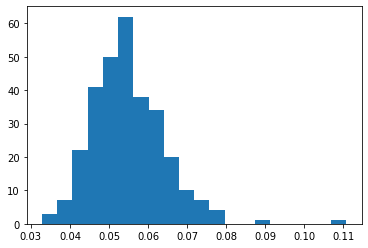

In [0]:
# plt.hist(score_0f, bins=100)
# plt.show()
# plt.hist(score_1f, bins=100)
# plt.show()
plt.hist(score_0r, bins=20)
plt.show()

In [0]:
# greedy search to find non-overlapping genes based solely on length
